In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import fftpack
from scipy import signal

In [417]:
sampling_rate = 4000
gain = 12
v_ref = 4.5
resolution = (2**23) - 1

<AxesSubplot:xlabel='timestamp'>

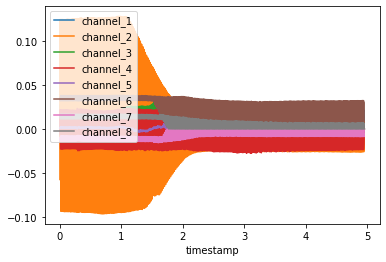

In [418]:
channel_data = np.load('channel_data.npy')
df = pd.DataFrame(data=channel_data.T).set_index(0)
df = (df * v_ref) / resolution
df /= gain
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df.iloc[10:].plot()

Text(0.5, 1.0, 'FFT of signal')

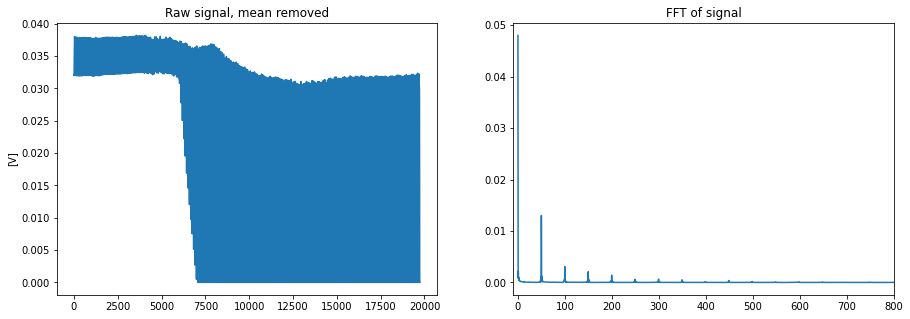

In [430]:
# Plot raw EMG signals and FFT
y = df.channel_6
y = y.to_numpy()
y = y[100:]
# y = y - y.mean()

N = len(y)
T = 1 / sampling_rate
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_fft = scipy.fftpack.fft(y)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y)
# plt.xlim(7000,8000)
plt.title('Raw signal, mean removed')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.xlim(-10, 800)
plt.title('FFT of signal')

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.05004841685872279

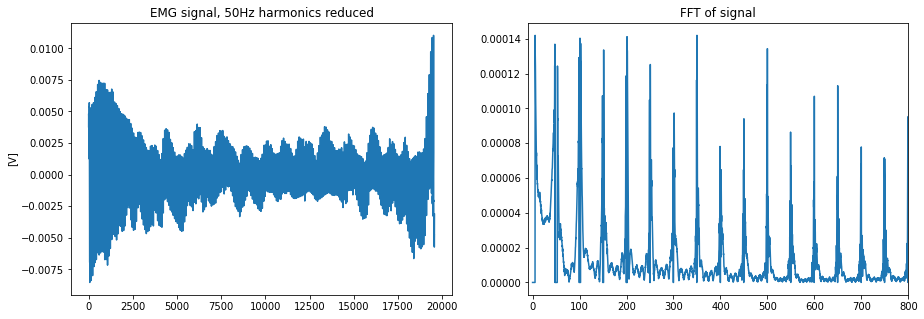

In [356]:
# Remove 50Hz harmonics from spectrum and transform back to time domain
psd = y_fft * np.conj(y_fft)/N
threshold = 0.0001
psd_idxs = psd < threshold
psd_clean = psd * psd_idxs
y_fft_clean = psd_idxs * y_fft
y_clean = scipy.fftpack.ifft(y_fft_clean)

y_fft_clean = 2.0/N * np.abs(y_fft_clean[:N//2])
y_clean = y_clean[100:-100]
fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y_clean)
# plt.xlim(10200,10700)
plt.title('EMG signal, 50Hz harmonics reduced')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(x, y_fft_clean)
plt.xlim(-10, 800)
plt.title('FFT of signal')
y.max() - y.min()

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

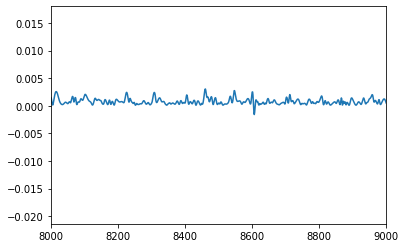

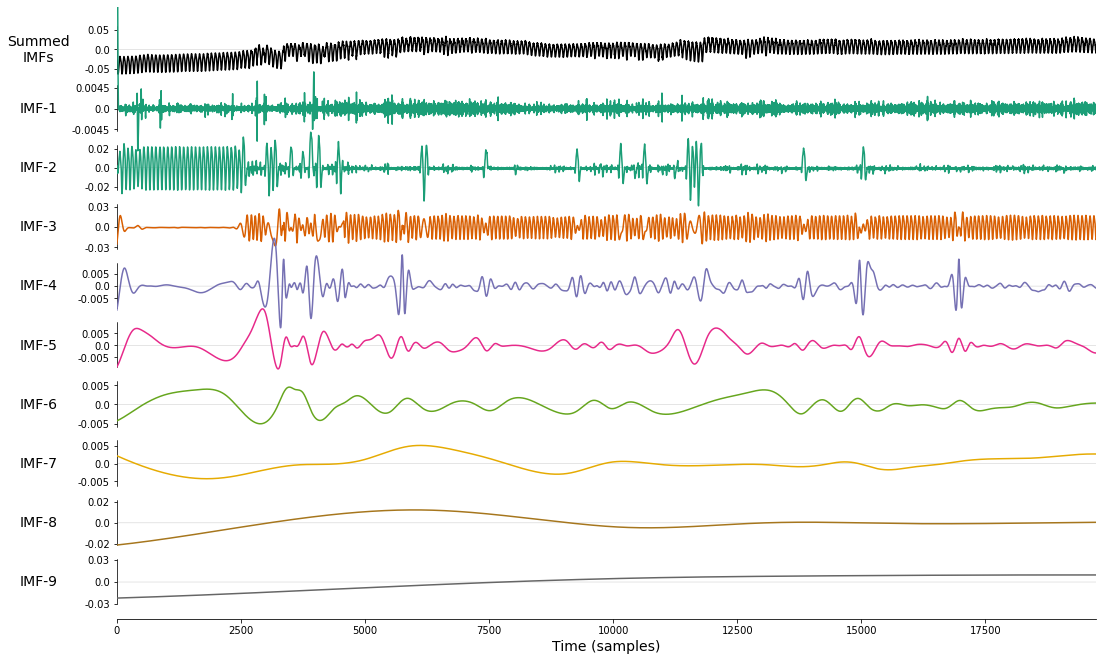

In [360]:
# EMD
import emd
seconds = 5
num_samples = seconds*sampling_rate

imf = emd.sift.sift(y - y.mean())
envelope = emd.sift.interp_envelope(imf, mode='upper')

plt.plot(envelope)
plt.xlim(8000,9000)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

Text(0.5, 1.0, 'FFT after bandpass filtering')

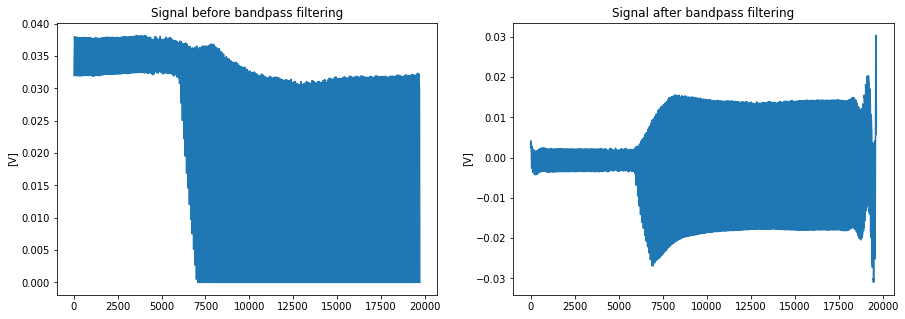

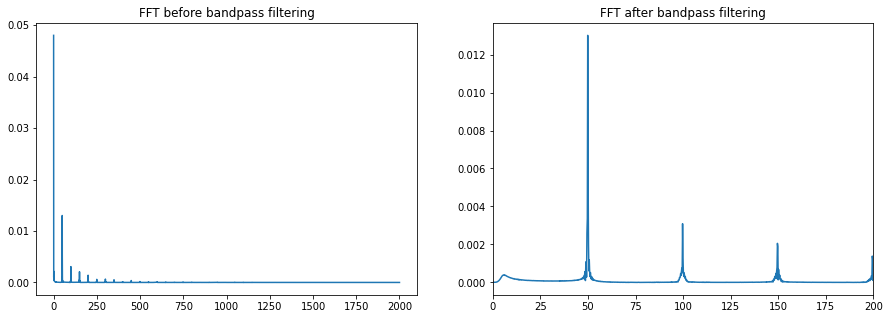

In [456]:
# Bandpass filter
high = 5       # Normalized to Nyquist rate
low = 400
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
y_butter = scipy.signal.filtfilt(b, a, y)
# y_butter = abs(y_butter)

y_butter_fft = scipy.fftpack.fft(y_butter)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y[1:])
# plt.xlim(7500,10000)
plt.title('Signal before bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_butter[100:])
# plt.xlim(7500,10000)
plt.title('Signal after bandpass filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before bandpass filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_butter_fft[:N//2]))
plt.xlim(0, 200)
plt.title('FFT after bandpass filtering')


Text(0.5, 1.0, 'FFT after notch filtering')

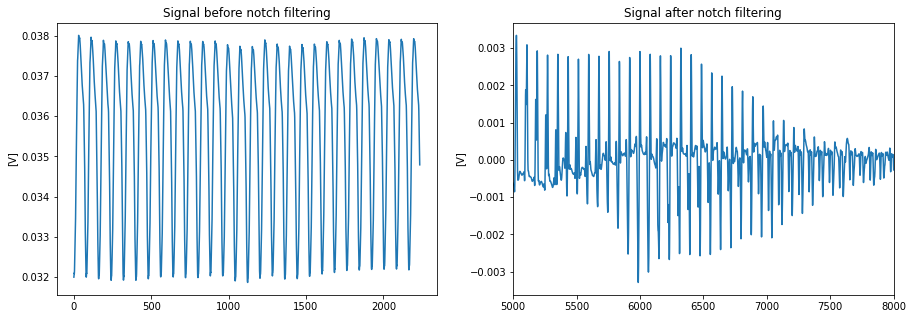

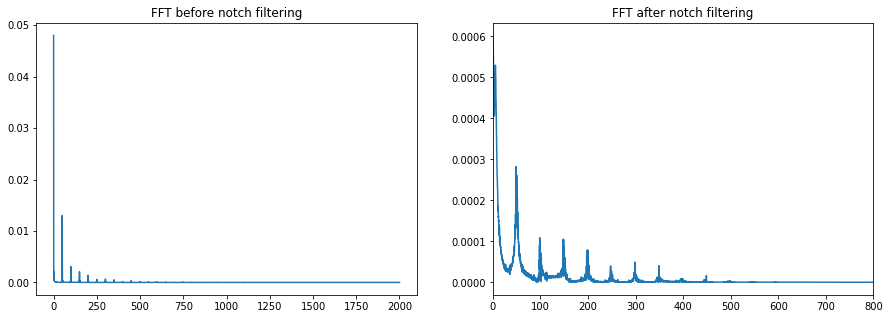

In [472]:
# Notch filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
y_notched = scipy.signal.filtfilt(b_notch, a_notch, y_butter)



y_notched_fft = scipy.fftpack.fft(y_notched)

b, a = scipy.signal.butter(4, 400, btype='lowpass', fs=sampling_rate)
y_filtered = scipy.signal.filtfilt(b, a, y_notched)
y_filtered_fft = scipy.fftpack.fft(y_notched)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y[1:-17500])
# plt.xlim(6000,8000)
plt.title('Signal before notch filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_notched[1000:-2000])
plt.xlim(5000, 8000)
plt.title('Signal after notch filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
# plt.xlim(0, 800)
plt.title('FFT before notch filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_notched_fft[:N//2]))
plt.xlim(0, 800)
plt.title('FFT after notch filtering')

Text(0, 0.5, '[V]')

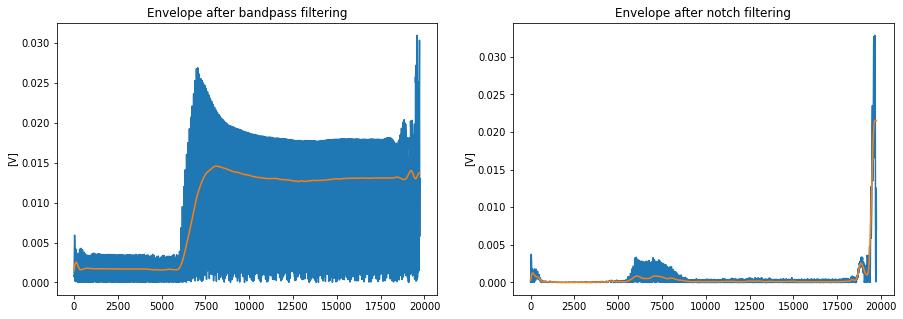

In [473]:
# Envelope
low_pass = 10/(sampling_rate/2)
b, a = scipy.signal.butter(3, low_pass, btype='lowpass')
envelope_b = scipy.signal.filtfilt(b, a, abs(y_butter))
envelope_n = scipy.signal.filtfilt(b, a, abs(y_notched))

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y_butter))
plt.plot(envelope_b)
plt.title('Envelope after bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched))
plt.plot(envelope_n)
plt.title('Envelope after notch filtering')
plt.ylabel('[V]')

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

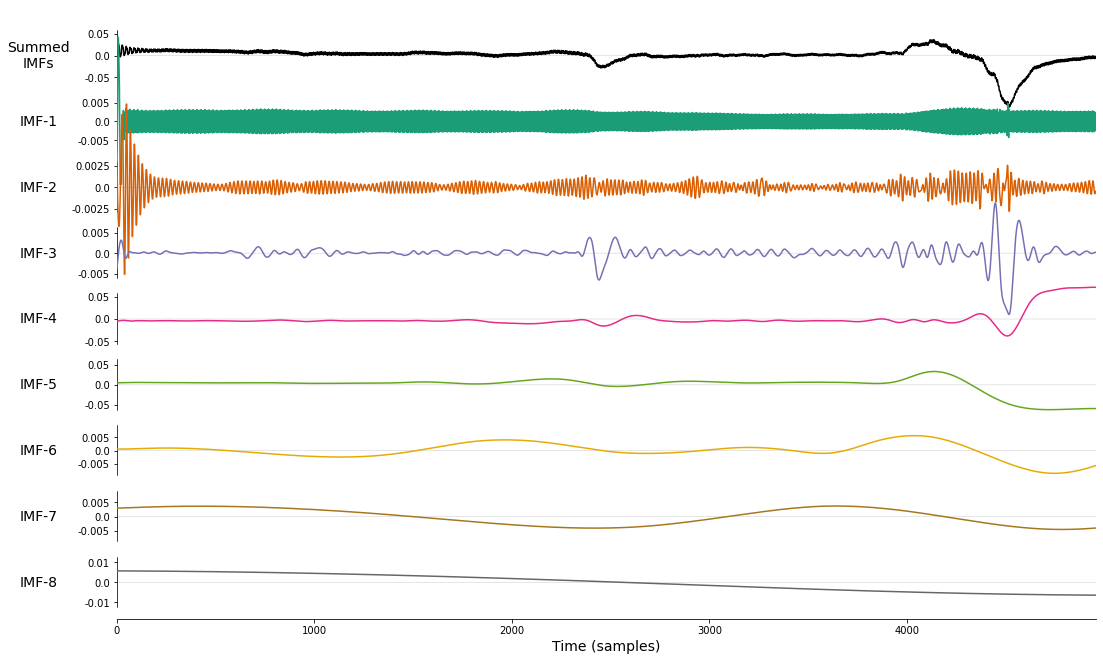

In [130]:
imf = emd.sift.sift(y_notched)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)